In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

# embedding = HuggingFaceEmbeddings(
#             model_name="../../../../Embedding/maidalun/bce-embedding-base_v1",
#             model_kwargs={"device": "cuda",
#                           "trust_remote_code": True},
#             encode_kwargs={"normalize_embeddings": True},
#         )

# Define the graph

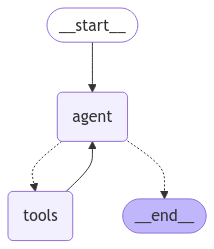

In [2]:
from langchain_core.callbacks import Callbacks
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

from langgraph.prebuilt import create_react_agent


@tool
async def get_items(
    place: str,
    callbacks: Callbacks,  # <--- Manually accept callbacks (needed for Python <= 3.10)
) -> str:
    """Use this tool to look up which items are in the given place."""
    # Attention when using async, you should be invoking the LLM using ainvoke!
    # If you fail to do so, streaming will not WORK.
    return await model.ainvoke(
        [
            {
                "role": "user",
                "content": f"Can you tell me what kind of items i might find in the following place: '{place}'. "
                "List at least 3 such items separating them by a comma. And include a brief description of each item..",
            }
        ],
        {"callbacks": callbacks},
    )


tools = [get_items]
agent = create_react_agent(model, tools=tools)

agent

# Using stream_mode="messages"

In [3]:
final_message = ""
async for msg, metadata in agent.astream(
    {"messages": [("human", "what items are on the shelf?")]}, stream_mode="messages"
):
    # Stream all messages from the tool node
    if (
        msg.content
        and not isinstance(msg, HumanMessage)
        and metadata["langgraph_node"] == "tools"
        and not msg.name
    ):
        print(msg.content, end="|", flush=True)
    # Final message should come from our agent
    if msg.content and metadata["langgraph_node"] == "agent":
        final_message += msg.content

In [5]:
final_message

'Could you please specify which shelf or location you are referring to?'

# Using stream events API

In [6]:
from langchain_core.messages import HumanMessage

async for event in agent.astream_events(
    {"messages": [{"role": "user", "content": "what's in the bedroom."}]}, version="v2"
):
    if (
        event["event"] == "on_chat_model_stream"
        and event["metadata"].get("langgraph_node") == "tools"
    ):
        print(event["data"]["chunk"].content, end="|", flush=True)